# 0 - Obtaining data from *journaldb*

In [1]:
import dotenv
import pendulum
from gjk.config import Settings
from gjk.models import ReadingSql
from sqlalchemy import create_engine, asc
from sqlalchemy.orm import sessionmaker
import pendulum
from gjk.models import ReadingSql
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

settings = Settings(_env_file=dotenv.find_dotenv())
engine = create_engine(settings.db_url.get_secret_value())
Session = sessionmaker(bind=engine)
session = Session()

timezone = "America/New_York"

start = pendulum.datetime(2024, 2, 3, 17, 0, tz=timezone)
end = pendulum.datetime(2024, 2, 3, 23, 0, tz=timezone)

start_ms = int(start.timestamp() * 1000)
end_ms = int(end.timestamp() * 1000)

In [2]:
ewt = session.query(ReadingSql).filter(
    ReadingSql.time_ms >= start_ms,
    ReadingSql.time_ms < end_ms,
    ReadingSql.data_channel_id == 'cecc9b94-9b4b-45ce-a8e9-4c63d24530aa').order_by(asc(ReadingSql.time_ms)).all()

lwt = session.query(ReadingSql).filter(
    ReadingSql.time_ms >= start_ms,
    ReadingSql.time_ms < end_ms,
    ReadingSql.data_channel_id == 'a49db047-e38f-44a4-b773-29102c2fc526').order_by(asc(ReadingSql.time_ms)).all()

mhp = session.query(ReadingSql).filter(
    ReadingSql.time_ms >= start_ms,
    ReadingSql.time_ms < end_ms,
    ReadingSql.data_channel_id == '94c3ab5c-7dd1-43c5-9870-733930251396').order_by(asc(ReadingSql.time_ms)).all()

odu = session.query(ReadingSql).filter(
    ReadingSql.time_ms >= start_ms,
    ReadingSql.time_ms < end_ms,
    ReadingSql.data_channel_id == '498da855-bac5-47e9-b83a-a11e56a50e67').order_by(asc(ReadingSql.time_ms)).all()

idu = session.query(ReadingSql).filter(
    ReadingSql.time_ms >= start_ms,
    ReadingSql.time_ms < end_ms,
    ReadingSql.data_channel_id == 'beabac86-7caa-4ab4-a50b-af1ad54ed165').order_by(asc(ReadingSql.time_ms)).all()

oat = session.query(ReadingSql).filter(
    ReadingSql.time_ms >= start_ms,
    ReadingSql.time_ms < end_ms,
    ReadingSql.data_channel_id == '49db0f92-1c25-46c0-b154-4f71923ce969').order_by(asc(ReadingSql.time_ms)).all()

# 1 - Estimating heating power output

## 1.1 - EWT and LWT

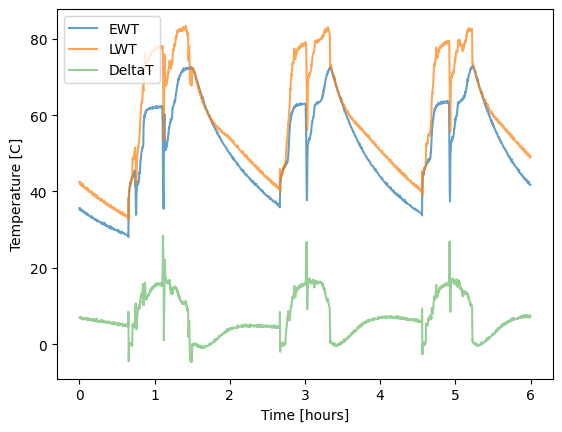

In [3]:
ewt_values = []
ewt_times = []
for e in ewt:
    if e.value > 0:
        ewt_values.append(e.value)
        ewt_times.append(e.time_ms)
ewt_times = [(x-ewt_times[0])/1000/60/60 for x in ewt_times]
ewt_values = [x/1000 for x in ewt_values]

lwt_values = []
lwt_times = []
for l in lwt:
    if l.value > 0:
        lwt_values.append(l.value)
        lwt_times.append(l.time_ms)
lwt_times = [(x-lwt_times[0])/1000/60/60 for x in lwt_times]
lwt_values = [x/1000 for x in lwt_values]

oat_values = []
oat_times = []
for o in oat:
    oat_values.append(o.value)
    oat_times.append(o.time_ms)
oat_times = [(x-oat_times[0])/1000/60/60 for x in oat_times]
oat_values = [x/1000 for x in oat_values]

df_ewt = pd.DataFrame({'time': ewt_times, 'ewt': ewt_values})
df_lwt = pd.DataFrame({'time': lwt_times, 'lwt': lwt_values})
df_ewt = df_ewt.sort_values('time')
df_lwt = df_lwt.sort_values('time')

# Merge on time and compute delta_t
df_ewt_lwt = pd.merge_asof(df_lwt, df_ewt, on='time')
df_ewt_lwt['delta_t'] = df_ewt_lwt['lwt'] - df_ewt_lwt['ewt']

plt.plot(df_ewt_lwt.time, df_ewt_lwt.ewt, alpha=0.7, label='EWT')
plt.plot(df_ewt_lwt.time, df_ewt_lwt.lwt, alpha=0.7, label='LWT')
plt.plot(df_ewt_lwt.time, df_ewt_lwt.delta_t, alpha=0.5, label="DeltaT")
plt.xlabel('Time [hours]')
plt.ylabel('Temperature [C]')
plt.legend(loc='upper left')
plt.show()

## 1.2 - Flow rate

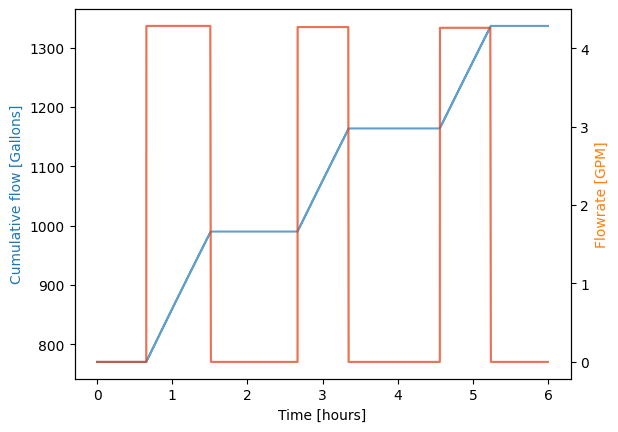

In [4]:
# Cumulative gallons
gallons_values = []
gallons_times = []
for m in mhp:
    gallons_values.append(m.value/100)
    gallons_times.append(m.time_ms)
gallons_times = [(x-gallons_times[0])/1000/60/60 for x in gallons_times]

# Convert to gpm
flow_values = []
flow_times = []

gallons_now = gallons_values[0]
time_now = gallons_times[0]

for i in range(len(gallons_values)):

    if gallons_values[i] > gallons_now:

        gpm = (gallons_values[i]-gallons_now)/(60*(gallons_times[i]-time_now))
        flow_values.append(gpm)
        flow_times.append(time_now)

        gallons_now = gallons_values[i]
        time_now = gallons_times[i]

# If the last cumulative gallons is the same as the last update (no flow since last point)
if gallons_values[-1] == gallons_now:
    flow_values.append(0)
    flow_times.append(time_now)

flow_values = [0 if x<1 else x for x in flow_values]
df_flowrate = pd.DataFrame({'time':flow_times, 'flowrate':flow_values})


def replace_with_section_mean(series):
    # Create a mask for positive values
    mask = series > 0
    # Find the sections of positive values
    sections = mask.ne(mask.shift()).cumsum()  # Change points create groups
    # Calculate the mean for each section of positive values
    section_means = series[mask].groupby(sections[mask]).transform('mean')
    # Replace positive values with their section mean
    series[mask] = section_means
    return series

df_flowrate['newflowrate'] = replace_with_section_mean(df_flowrate['flowrate'])

df_flowrate = df_flowrate.sort_values('time')
df_ewt_lwt = df_ewt_lwt.sort_values('time')

# Merge on time with temperature values
df_heatpower = pd.merge_asof(df_ewt_lwt, df_flowrate, on='time')

fig, ax = plt.subplots(1,1)
ax.plot(gallons_times, gallons_values, alpha=0.7)
ax.set_xlabel('Time [hours]')
ax.set_ylabel('Cumulative flow [Gallons]', color='tab:blue')
ax2 = ax.twinx()
ax2.plot(df_heatpower.time, df_heatpower.flowrate, alpha=0.5, color='tab:orange')
ax2.plot(df_heatpower.time, df_heatpower.newflowrate, alpha=0.5, color='tab:red')
ax2.set_ylabel('Flowrate [GPM]', color='tab:orange')
plt.show()

## 1.3 - Heating power ouput

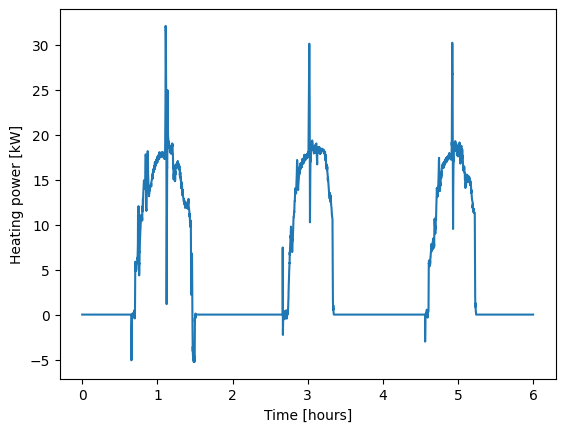

In [5]:
df_heatpower['Q_HP'] = (3.78541 * df_heatpower.newflowrate / 60) * 4187 * df_heatpower.delta_t / 1000

plt.plot(df_heatpower.time, df_heatpower.Q_HP)
plt.xlabel('Time [hours]')
plt.ylabel('Heating power [kW]')
plt.show()

# 2 - Estimating electrical power input

Data length before resampling: 879, after resampling: 21478


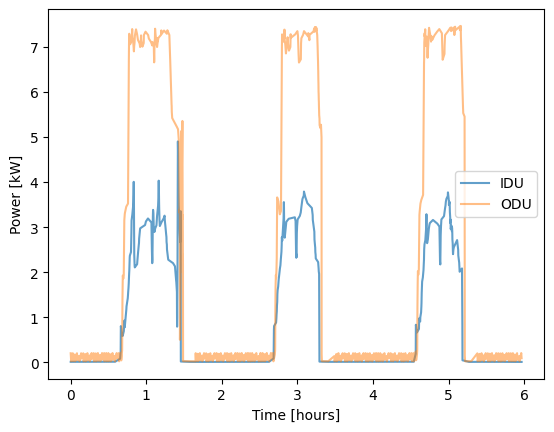

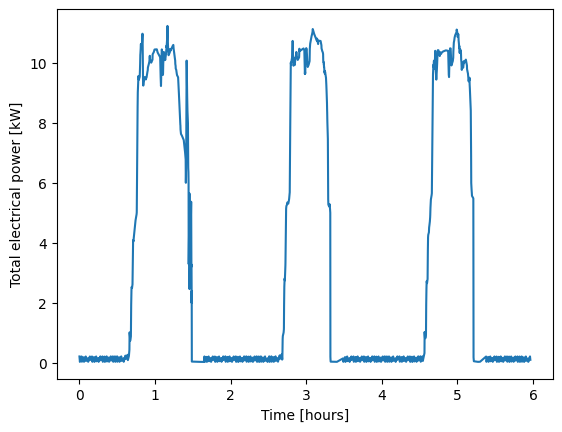

In [6]:
idu_values = []
idu_times = []
for x in idu:
    if x.value > 0:
        idu_values.append(x.value/1000)
        idu_times.append(x.time_ms)
idu_times = [(x-idu_times[0])/1000/60/60 for x in idu_times]

odu_values = []
odu_times = []
for x in odu:
    if x.value > 0:
        odu_values.append(x.value/1000)
        odu_times.append(x.time_ms)
odu_times = [(x-odu_times[0])/1000/60/60 for x in odu_times]

df_idu = pd.DataFrame({'time':idu_times, 'idu':idu_values})
df_odu = pd.DataFrame({'time':odu_times, 'odu':odu_values})
df_idu = df_idu.sort_values('time')
df_odu = df_odu.sort_values('time')

df_odu['time'] = pd.to_datetime(df_odu['time']*3600, unit='s')
df_idu['time'] = pd.to_datetime(df_idu['time']*3600, unit='s')
df_odu.set_index('time', inplace=True)
df_idu.set_index('time', inplace=True)

# Resample both DataFrames to a common frequency (e.g., 1 second)
df_odu_resampled = df_odu.resample('s').mean().interpolate()
df_idu_resampled = df_idu.resample('s').mean().interpolate()

# Merge using merge_asof on the resampled DataFrames
df_elecpower = pd.merge_asof(df_odu_resampled, df_idu_resampled, on='time', direction='backward')
df_elecpower['time'] = (df_elecpower['time'] - df_elecpower['time'].min()).dt.total_seconds() / 3600
df_elecpower['W_HP'] = df_elecpower.idu + df_elecpower.odu

print(f"Data length before resampling: {len(odu_times)}, after resampling: {len(df_elecpower)}")

plt.plot(df_elecpower.time, df_elecpower.idu, alpha=0.7, label='IDU')
plt.plot(df_elecpower.time, df_elecpower.odu, alpha=0.5, label='ODU')
plt.xlabel('Time [hours]')
plt.ylabel('Power [kW]')
plt.legend()
plt.show()

plt.plot(df_elecpower.time, df_elecpower.W_HP)
plt.xlabel('Time [hours]')
plt.ylabel('Total electrical power [kW]')
plt.show()

# 3 - Estimating COP

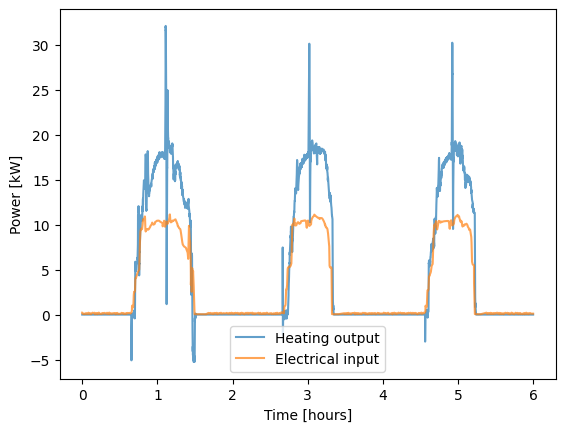

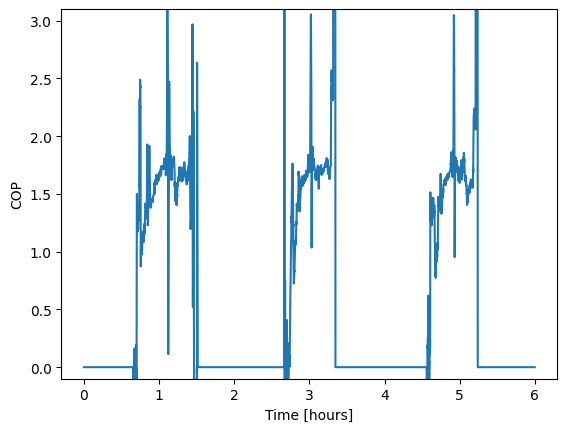

In [7]:
# Merge elec power and heating power
final = pd.merge_asof(df_heatpower, df_elecpower, on='time')
final['COP'] = final.Q_HP/final.W_HP

plt.plot(final.time, final.Q_HP, alpha=0.7, label='Heating output')
plt.plot(final.time, final.W_HP, alpha=0.7, label='Electrical input')
plt.xlabel('Time [hours]')
plt.ylabel('Power [kW]')
plt.legend()
plt.show()

plt.plot(final.time, final.COP)
plt.xlabel('Time [hours]')
plt.ylabel('COP')
plt.ylim([-0.1,3.1])
plt.show()

# 4 - Adding outside air temperature

In [8]:
try:
    from weather import get_temp
    oat_herbie = []
    for hour in range(int((end-start).total_hours())):
        print(f"Finding weather at {start.add(hours=hour)}...")
        oat_herbie.append(get_temp(start.add(hours=hour)))
except:
    print("Couldn't get Herbie weather for all points")
    oat_herbie = []

 ╭─▌▌Herbie─────────────────────────────────────────────╮
 │ WARNING: Unable to create config file               │
 │      /Users/thomas/.config/herbie/config.toml        │
 │ Herbie will use standard default settings.           │
 │ Consider setting env variable HERBIE_CONFIG_PATH.    │
 ╰──────────────────────────────────────────────────────╯

Finding weather at 2024-02-03 17:00:00-05:00...
✅ Found ┊ model=hrrr ┊ product=sfc ┊ 2024-Feb-03 22:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
Finding weather at 2024-02-03 18:00:00-05:00...
✅ Found ┊ model=hrrr ┊ product=sfc ┊ 2024-Feb-03 23:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
Finding weather at 2024-02-03 19:00:00-05:00...
✅ Found ┊ model=hrrr ┊ product=sfc ┊ 2024-Feb-04 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
Finding weather at 2024-02-03 20:00:00-05:00...
✅ Found ┊ model=hrrr ┊ product=sfc ┊ 2024-Feb-04 01:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
Finding weather at 2024-02-03 21:00:00-05:00...
✅ Found ┊ model=hrrr ┊ product=sfc ┊ 2024-Feb-04 02:00 U

In [9]:
# Add the herbie OAT
if oat_herbie:
    hour_bins = [-1]+list(range(1,int(max(final.time))+2,1))
    final['oat_herbie'] = pd.cut(final['time'], bins=hour_bins, labels=oat_herbie, ordered=False)

# Add the gridworks OAT
df_oat = pd.DataFrame({'time': oat_times, 'oat': oat_values})
final = pd.merge_asof(final, df_oat, on='time')
final = final.round(3)

# Bring back to datetime
initial_time = start_ms/1000
final['time_dt'] = final.time*3600 + initial_time
final['time_dt'] = pd.to_datetime(final['time_dt'], unit='s')

if 'oat_herbie' in final.columns:
    final = final[['time_dt', 'time', 'oat', 'oat_herbie', 'ewt', 'lwt', 'delta_t', 'flowrate', 'odu', 'idu', 'Q_HP', 'W_HP', 'COP']]
else:
    final = final[['time_dt', 'time', 'oat', 'ewt', 'lwt', 'delta_t', 'flowrate', 'odu', 'idu', 'Q_HP', 'W_HP', 'COP']]

display(final)

,time_dt,time,oat,oat_herbie,ewt,lwt,delta_t,flowrate,odu,idu,Q_HP,W_HP,COP
0,2024-02-03 22:00:00.000000000,0.000,-2.156,-5.89,35.617,42.517,6.900,0.0,0.204,0.014,0.0,0.218,0.0
1,2024-02-03 22:00:00.000000000,0.000,-2.156,-5.89,35.355,42.219,6.864,0.0,0.204,0.014,0.0,0.218,0.0
2,2024-02-03 22:00:36.000000000,0.010,-2.156,-5.89,35.097,41.962,6.865,0.0,0.039,0.014,0.0,0.053,0.0
3,2024-02-03 22:00:39.599999905,0.011,-2.156,-5.89,35.184,42.263,7.079,0.0,0.043,0.014,0.0,0.057,0.0
4,2024-02-03 22:00:39.599999905,0.011,-2.156,-5.89,35.184,41.966,6.782,0.0,0.045,0.014,0.0,0.059,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3138,2024-02-04 03:59:02.400000095,5.984,-5.428,-10.38,42.185,49.682,7.497,0.0,0.094,0.012,0.0,0.106,0.0
3139,2024-02-04 03:59:02.400000095,5.984,-5.428,-10.38,42.185,49.192,7.007,0.0,0.094,0.012,0.0,0.106,0.0
3140,2024-02-04 03:59:34.799999952,5.993,-5.428,-10.38,41.740,48.941,7.201,0.0,0.094,0.012,0.0,0.106,0.0
3141,2024-02-04 03:59:52.799999952,5.998,-5.428,-10.38,41.706,49.212,7.506,0.0,0.094,0.012,0.0,0.106,0.0


# 5 - Saving CSVs

In [10]:
from ipywidgets import FloatSlider, interactive, Checkbox

def crop(min_time, max_time, save):

    df_crop = final.copy()
    df_crop = df_crop[df_crop.time > min_time]
    df_crop = df_crop[df_crop.time < max_time]
    
    # Create file name
    timestamp = int(list(df_crop.time_dt)[0].timestamp())
    csv_name = f"{timestamp}_lwt{round(np.mean(df_crop.lwt))}_oat{round(list(df_crop.oat)[0])}.csv".replace('-', 'neg')

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
    ax1.plot(df_crop.time, df_crop.Q_HP, alpha=0.7, label='Heat')
    ax1.plot(df_crop.time, df_crop.W_HP, alpha=0.7, label='Elec')
    ax1.plot(df_crop.time, df_crop.lwt, alpha=0.7, label='LWT')
    ax1.plot(df_crop.time, df_crop.ewt, alpha=0.7, label='EWT')
    ax1.plot(df_crop.time, df_crop.oat, alpha=0.7, label='OAT')
    # ax1.plot(df_crop.time, df_crop.oat_herbie, alpha=0.7, label='OAT')
    ax1.legend(loc='upper left')
    ax1.set_xlabel('Time [hours]')
    ax2.plot(df_crop.time, df_crop.COP)
    ax2.set_xlabel('Time [hours]')
    ax2.set_ylabel('COP')
    ax2.set_ylim([0, 5])
    ax1.set_title(csv_name)
    plt.tight_layout()
    if save:
        if len(df_crop) < 1000:
            plt.savefig(f"/Users/thomas/Desktop/data/{csv_name.replace('.csv','.png')}")
            df_crop['time'] = df_crop['time_dt'].astype('int64') 
            df_crop['time'] = (df_crop['time'] - list(df_crop['time'])[0]) / 1e9
            df_crop.to_csv(f'/Users/thomas/Desktop/data/{csv_name}')
            print(f"Saved {csv_name}")
        else:
            print("Too long")
    plt.show()

    display(df_crop.head())

min_slider = FloatSlider(value=final['time'].min(), min=final['time'].min(), max=final['time'].max(), step=0.01, description='min')
max_slider = FloatSlider(value=final['time'].max(), min=final['time'].min(), max=final['time'].max(), step=0.01, description='max')
save_checkbox = Checkbox(value=False, description='Save')

interactive(crop, min_time=min_slider, max_time=max_slider, save=save_checkbox)

interactive(children=(FloatSlider(value=0.0, description='min', max=5.998, step=0.01), FloatSlider(value=5.998…

# 6 - Regression

In [14]:
import os

big_df = pd.DataFrame()

for file in os.listdir('/Users/thomas/Desktop/data/'):
    if '.csv' in file:
        df = pd.read_csv(f'/Users/thomas/Desktop/data/{file}')
        df.drop(columns=['time', 'Unnamed: 0'], inplace=True)
        big_df = pd.concat([big_df, df], ignore_index=True) 

display(big_df)

,time_dt,oat,ewt,lwt,delta_t,flowrate,odu,idu,Q_HP,W_HP,COP,oat_herbie
0,2024-02-07 12:18:03.599999905,-7.827,70.182,76.670,6.488,8.128,7.418,2.702,13.931,10.120,1.377,NaN
1,2024-02-07 12:18:18.000000000,-7.827,70.531,76.974,6.443,8.128,7.484,2.703,13.834,10.187,1.358,NaN
2,2024-02-07 12:18:46.799999952,-7.911,70.785,77.249,6.464,8.128,7.406,2.705,13.880,10.111,1.373,NaN
3,2024-02-07 12:19:08.400000095,-7.911,71.132,77.548,6.416,8.128,7.390,2.707,13.776,10.097,1.364,NaN
4,2024-02-07 12:19:12.000000000,-7.911,71.132,77.194,6.062,8.128,7.390,2.707,13.016,10.097,1.289,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
1760,2024-02-12 07:16:12.000000000,4.673,59.180,72.204,13.024,6.282,7.323,3.269,21.613,10.592,2.040,0.46
1761,2024-02-12 07:16:12.000000000,4.673,59.199,71.940,12.741,6.282,7.322,3.264,21.143,10.586,1.997,0.46
1762,2024-02-12 07:16:12.000000000,4.673,59.467,72.214,12.747,6.282,7.322,3.264,21.153,10.586,1.998,0.46
1763,2024-02-12 07:16:58.799999952,4.673,59.460,72.576,13.116,6.282,7.345,3.149,21.765,10.494,2.074,0.46


In [15]:
from scipy.optimize import curve_fit

def model(X,a,b,c):
    x1, x2 = X
    approx = a + b*x1 + c*x2
    return approx

x_o = np.array(list(big_df.oat))
x_l = np.array(list(big_df.lwt))
X_list = np.vstack((x_o, x_l))
y = np.array(list(big_df.COP))

popt, pcov = curve_fit(model, X_list, y)
big_df['COP_approx'] = model(X_list, *popt)
print(popt)

def COP(oat,lwt):
    return model([oat,lwt], *popt)

display(big_df)

[ 2.34770006  0.02707313 -0.00670455]


,time_dt,oat,ewt,lwt,delta_t,flowrate,odu,idu,Q_HP,W_HP,COP,oat_herbie,COP_approx
0,2024-02-07 12:18:03.599999905,-7.827,70.182,76.670,6.488,8.128,7.418,2.702,13.931,10.120,1.377,NaN,1.621761
1,2024-02-07 12:18:18.000000000,-7.827,70.531,76.974,6.443,8.128,7.484,2.703,13.834,10.187,1.358,NaN,1.619723
2,2024-02-07 12:18:46.799999952,-7.911,70.785,77.249,6.464,8.128,7.406,2.705,13.880,10.111,1.373,NaN,1.615605
3,2024-02-07 12:19:08.400000095,-7.911,71.132,77.548,6.416,8.128,7.390,2.707,13.776,10.097,1.364,NaN,1.613600
4,2024-02-07 12:19:12.000000000,-7.911,71.132,77.194,6.062,8.128,7.390,2.707,13.016,10.097,1.289,NaN,1.615974
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1760,2024-02-12 07:16:12.000000000,4.673,59.180,72.204,13.024,6.282,7.323,3.269,21.613,10.592,2.040,0.46,1.990118
1761,2024-02-12 07:16:12.000000000,4.673,59.199,71.940,12.741,6.282,7.322,3.264,21.143,10.586,1.997,0.46,1.991888
1762,2024-02-12 07:16:12.000000000,4.673,59.467,72.214,12.747,6.282,7.322,3.264,21.153,10.586,1.998,0.46,1.990051
1763,2024-02-12 07:16:58.799999952,4.673,59.460,72.576,13.116,6.282,7.345,3.149,21.765,10.494,2.074,0.46,1.987624


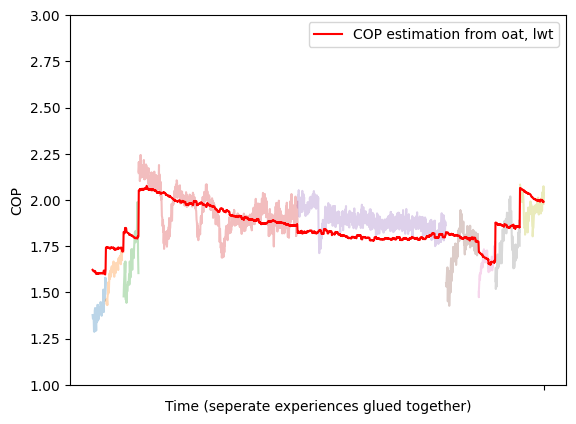

In [16]:
big_df = pd.DataFrame()
for file in os.listdir('/Users/thomas/Desktop/data/'):
    if '.csv' in file:
        df = pd.read_csv(f'/Users/thomas/Desktop/data/{file}')
        df.drop(columns=['time', 'Unnamed: 0'], inplace=True)
        big_df = pd.concat([big_df, df], ignore_index=True)
        plt.plot(df.time_dt, df.COP, alpha=0.3)
big_df['COP_approx'] = big_df.apply(lambda row: COP(row['oat'], row['lwt']), axis=1)
plt.plot(big_df.time_dt, big_df.COP_approx, color='red', label='COP estimation from oat, lwt')
plt.legend()
plt.ylim([1,3])
plt.xticks([''])
plt.xlabel('Time (seperate experiences glued together)')
plt.ylabel('COP')
plt.show()

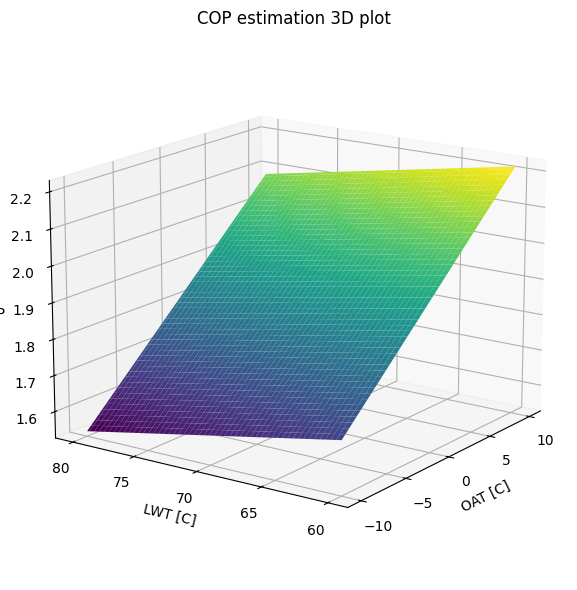

In [17]:
oat_range = np.linspace(-10, 10, 100)
lwt_range = np.linspace(60, 80, 100)
oat_grid, lwt_grid = np.meshgrid(oat_range, lwt_range)
cop_values = COP(oat_grid, lwt_grid)

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(oat_grid, lwt_grid, cop_values, cmap='viridis')
ax.view_init(elev=16, azim=-145)
ax.set_xlabel('OAT [C]')
ax.set_xticks([-10,-5,0,5,10])
ax.set_ylabel('LWT [C]')
ax.set_yticks([60,65,70,75,80])
ax.set_zlabel('COP')
ax.set_title('COP estimation 3D plot')
plt.tight_layout()
plt.show()

In [18]:
df = pd.DataFrame({'OAT':list(range(-25,20,5))})
for lwt in range(30,70,5):
    df[f'LWT={lwt}'] = [round(COP(x,lwt),2) for x in range(-25,20,5)]
display(df)

,OAT,LWT=30,LWT=35,LWT=40,LWT=45,LWT=50,LWT=55,LWT=60,LWT=65
0,-25,1.47,1.44,1.40,1.37,1.34,1.30,1.27,1.24
1,-20,1.61,1.57,1.54,1.50,1.47,1.44,1.40,1.37
2,-15,1.74,1.71,1.67,1.64,1.61,1.57,1.54,1.51
3,-10,1.88,1.84,1.81,1.78,1.74,1.71,1.67,1.64
4,-5,2.01,1.98,1.94,1.91,1.88,1.84,1.81,1.78
5,0,2.15,2.11,2.08,2.05,2.01,1.98,1.95,1.91
6,5,2.28,2.25,2.21,2.18,2.15,2.11,2.08,2.05
7,10,2.42,2.38,2.35,2.32,2.28,2.25,2.22,2.18
8,15,2.55,2.52,2.49,2.45,2.42,2.39,2.35,2.32
